<a href="https://colab.research.google.com/github/jasxn808/Simple-Linear-Regression/blob/main/Simple_Linear_Regression_RYOE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# simple = only 1 predictor variable + intercept
# linear = straight line
# regression = observations should return/regress to avg over time

# simulating small-scale RYOE
  # ydstogo


In [2]:
pip install nfl_data_py

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.5 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13187 sha256=adfeabfd1facd3e1a83b6d5bc9986e1438f8c2301ebf63fc65e2e512cd2d830a
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py


In [3]:
pip install statsmodels

In [4]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

seasons = range(2021, 2022 + 1)
pbp_py = nfl.import_pbp_data(seasons)

2021 done.
2022 done.
Downcasting floats.


In [5]:
#After loading the data, select the running plays. Use the filtering criteria play_type == "run". Also, remove the plays without a rusher and replace the missing rushing yards with 0.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#pbp_py.columns.tolist()

#play_type == run
#rusher != None
#rushing_yards
  #rusher_player_id, ruhser_player_name

pbp_py_run = \
pbp_py\
  .query('play_type == "run" & rusher.notna()')

pbp_py_run['rushing_yards'] = np.where(pbp_py_run['rushing_yards'].isnull(), 0, pbp_py_run['rushing_yards'])
#pbp_py_run.loc[pbp_py_run.rushing_yards.isnull(), "rushing_yards"] == 0

<ipython-input-5-a1189febad60>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_py_run['rushing_yards'] = np.where(pbp_py_run['rushing_yards'].isnull(), 0, pbp_py_run['rushing_yards'])


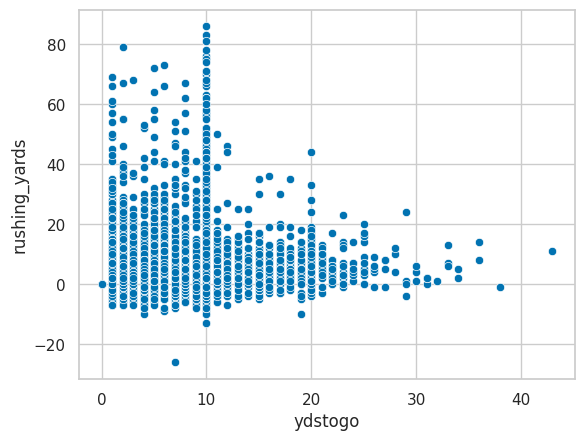

In [6]:
## plotting raw data:

sns.set_theme(style="whitegrid", palette="colorblind")
sns.scatterplot(data=pbp_py_run, x="ydstogo", y="rushing_yards");
plt.show();

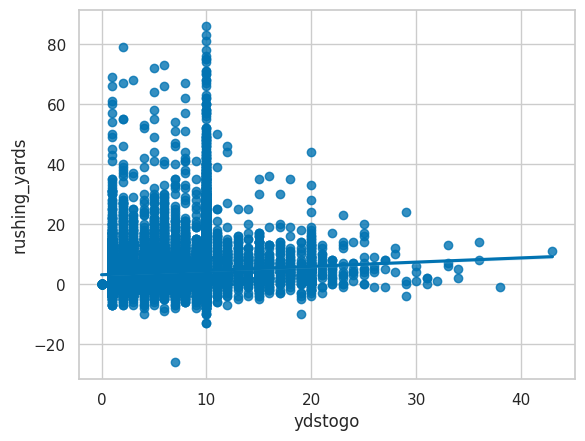

In [7]:
# adding trend line:
sns.regplot(data=pbp_py_run, x='ydstogo', y='rushing_yards');
plt.show();


#small positive slope -> rushing gains increase as yards_to_go increases

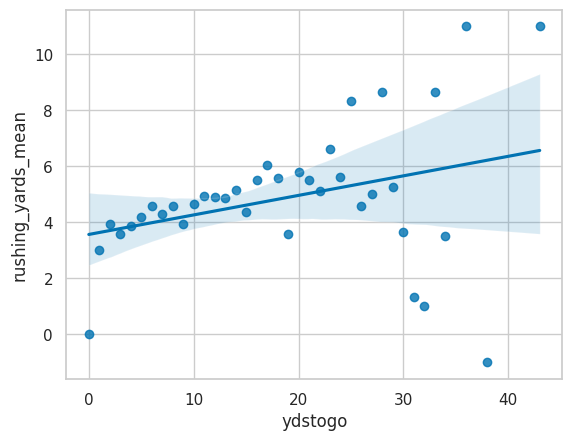

In [8]:
#Now, average over each yards-per-carry value gained
pbp_py_run_agg = \
pbp_py_run \
  .groupby(['ydstogo'])\
  .agg({'rushing_yards':['mean']})


pbp_py_run_agg.columns = list(map('_'.join, pbp_py_run_agg.columns))

pbp_py_run_agg.reset_index(inplace=True)

sns.regplot(data=pbp_py_run_agg, x='ydstogo', y='rushing_yards_mean');
plt.show();

##positive linear relationship b/w avg yds gained + ydstogo
  ##is it worth doing linear regression? yes

In [9]:
##simply linear regression:
#formula: rushing_yards ~ 1 + ydstogo

#build model:
yard_to_go_py = \
    smf.ols(formula='rushing_yards ~ 1 + ydstogo', data=pbp_py_run)
#fit model:
print(yard_to_go_py.fit().summary())

# If R-squared = 1.0, the model fits the data perfectly. Conversely, if
# R-squared = 0, the model does not predict the data at all. In this case, the low
# R-squ of 0.008 shows that the simple model does not predict the data well.


#rushing play with 2 yards to go: 3.2(intercept) + 0.1402(slope) * 2(yards to go) = 3.4 yards on avg

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     224.0
Date:                Thu, 12 Oct 2023   Prob (F-statistic):           1.87e-50
Time:                        04:18:05   Log-Likelihood:                -89755.
No. Observations:               27881   AIC:                         1.795e+05
Df Residuals:                   27879   BIC:                         1.795e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2343      0.082     39.647      0.0

In [10]:
pbp_py_run['ryoe'] = \
    yard_to_go_py\
    .fit()\
    .resid

#Residuals are the difference between a model’s expected (or predicted) output and the observed data

<ipython-input-10-d2a8ebf1de4c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_py_run['ryoe'] = \


In [32]:
ryoe_py =\
pbp_py_run\
  .groupby(['season','rusher_id', 'rusher'])\
  .agg({'ryoe':['count','sum','mean']\
       , 'rushing_yards':['mean']}\
       )

ryoe_py.columns = list(map('_'.join, ryoe_py.columns))
ryoe_py.reset_index(inplace=True)


ryoe_py.rename(columns = \
                {'ryoe_count': 'n'\
                 ,'ryoe_sum':'ryoe_total'\
                 ,'ryoe_mean':'ryoe_per'\
                 ,'rushing_yards_mean':'yards_per_carry'\
                }\
               ,inplace=True)

ryoe_py = ryoe_py.query('n > 50')

ryoe_py.sort_values('ryoe_total', ascending=False)

,season,rusher_id,rusher,n,ryoe_total,ryoe_per,yards_per_carry
67,2021,00-0036223,J.Taylor,332,394.338099,1.187765,5.454819
114,2022,00-0034796,L.Jackson,73,271.369379,3.717389,7.821918
42,2021,00-0034791,N.Chubb,228,258.499687,1.133771,5.521930
41,2021,00-0034750,R.Penny,119,219.817171,1.847203,6.294117
149,2022,00-0036973,T.Etienne,251,210.592817,0.839015,5.163347
95,2022,00-0033293,A.Jones,213,193.975744,0.910684,5.262911
113,2022,00-0034791,N.Chubb,303,185.586322,0.612496,5.033003
124,2022,00-0035700,J.Jacobs,341,177.780610,0.521351,4.847507
97,2022,00-0033357,T.Hill,96,171.811767,1.789706,5.989583
120,2022,00-0035261,T.Pollard,214,157.090674,0.734069,5.168224


In [33]:
ryoe_py.sort_values('ryoe_per', ascending = False)

,season,rusher_id,rusher,n,ryoe_total,ryoe_per,yards_per_carry
114,2022,00-0034796,L.Jackson,73,271.369379,3.717389,7.821918
41,2021,00-0034750,R.Penny,119,219.817171,1.847203,6.294117
148,2022,00-0036945,J.Fields,85,154.028555,1.812101,6.000000
97,2022,00-0033357,T.Hill,96,171.811767,1.789706,5.989583
35,2021,00-0034253,D.Hilliard,56,95.957461,1.713526,6.250000
112,2022,00-0034750,R.Penny,57,94.753072,1.662335,6.070176
125,2022,00-0035710,D.Jones,63,93.790915,1.488745,5.555555
63,2021,00-0035719,D.Samuel,86,121.759556,1.415809,5.837209
158,2022,00-0038120,Br.Hall,80,106.232224,1.327903,5.787500
48,2021,00-0034857,J.Allen,80,104.729086,1.309114,5.337500


In [69]:
##stability analysis:

cols_keep = \
  ['season', 'rusher_id', 'rusher'\
   ,'ryoe_per', 'yards_per_carry'
  ]

ryoe_py_LY = ryoe_py.copy()




ryoe_py_LY['season'] += 1

ryoe_both = \
  ryoe_py\
    .merge(ryoe_py_LY\
          , how='left'\
           , on=['season', 'rusher_id', 'rusher']
           ).fillna(0) [['season','rusher_id', 'rusher', 'n_x', 'ryoe_per_x', 'yards_per_carry_x', 'ryoe_per_y', 'yards_per_carry_y']]



ryoe_both.rename(columns = {'n_x':'n', 'ryoe_per_x':'ryoe_per_CY', 'yards_per_carry_x': 'ypc_CY', 'ryoe_LY':'ryoe_per_LY', 'yards_per_carry_y':'ypc_LY'}, inplace=True)
ryoe_both.query('rusher == "J.Taylor"')


In [73]:
## correlation for ypc:
ryoe_both[['ypc_LY','ypc_CY']].corr()



,ypc_LY,ypc_CY
ypc_LY,1.000000,0.142212
ypc_CY,0.142212,1.000000


In [74]:
ryoe_both[['ryoe_per_CY', 'ryoe_per_LY']].corr()

#ryoe = slightly more stable metric than YPC (corr coefficient = larger)

,ryoe_per_CY,ryoe_per_LY
ryoe_per_CY,1.000000,0.213482
ryoe_per_LY,0.213482,1.000000
